# Approximations for Exiotic Call


## PART 0: Introduction of the option

Knock in/down Option

The payoff of European option at expiration date is:
#### $$Above Strike:  weight  * (S_T-K )$$
#### $$Below Strike:  (1-weight)  * (K-S_T )$$


where $S_T $ is the spot price at maturity, $K$ is the strike price

## PART 1: MC
-GBM path

In [1]:
import datetime
import numpy as np
import scipy.stats as ss
import numpy.polynomial as nppoly
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, pi
from scipy.stats import norm

In [2]:
np.random.seed(1234567) # seed

In [3]:
def gen_paths (S0, r, sigma, T, M, I):
    ''' Generate Monte Carlo paths for geometric Brownian motion.
    
    Parameters
    ==========
    S0 : float
        initial stock/index value
    r : float
        constant short rate
    sigma : float
        constant volatility
    T : float
        final time horizon
    M : int
        number of time steps/intervals
    I : int
        number of paths to be simulated
        
    Returns
    =======
    paths : ndarray, shape (M + 1, I)
        simulated paths given the parameters
    '''
    dt = float(T) / M
    paths = np.zeros((M + 1, I), np.float64)
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal(I)
        rand = (rand - rand.mean()) / rand.std()
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * rand)
    return paths

### Assumptions

In [4]:
S = 600 # Underlying price
v = 0.2 # vol
r = 0.01 # risk free rate
T = (datetime.date(2018,8,15)-datetime.date(2018,7,16)).days/365 # time to maturity
K = 580 # strike
weight = 0.5 # weight-above strike
simulations = 10000 # no. of simulation
M = 200 # no. of time step

In [5]:
paths = gen_paths(S, r, v, T, M, simulations)

In [6]:
sns.set(rc = {"figure.figsize":(10,8)})
sns.set_palette(sns.color_palette("Set1"))

### Simulated Price Paths

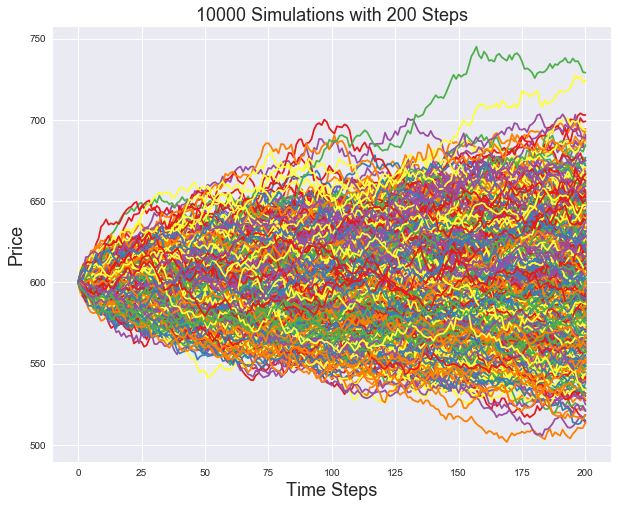

In [7]:
plt.plot(paths[:, :1000])
plt.grid(True)
plt.title(' %d Simulations with %d Steps ' %(simulations,M),fontsize =18)
plt.xlabel('Time Steps',fontsize =18)
plt.ylabel('Price',fontsize =18)
# tag: normal_sim_1
# title: 1000 simulated paths of geometric Brownian motion
plt.show()

In [8]:
def N(x):
    """ Normal cumulative function
    :param x:
    :return:
    """
    return norm.cdf(x)


def phi(z):
    """ Phi helper function
    :param z:
    :return:
    """
    return np.exp(-0.5 * z * z) / (sqrt(2.0 * pi))


def BS_value(s, k, r, t, vol,Type):
    """ Black-Scholes call option
    :param s: underlying
    :param k: strike price
    :param r: rate
    :param t: time to expiration
    :param vol: volatility
    :return: Black call option value
    """
    if (Type == 'C'):
        d1 = (np.log(s / k) + ( 0.5 * vol ** 2.0) * t) / (vol * np.sqrt(t))


        y = s*np.exp(-r * t) *  N(d1) - k * np.exp(-r * t) * N(d1 - vol * np.sqrt(t))

    else:

        d1 = (np.log(s / k) + (0.5 * vol ** 2.0) * t) / (vol * np.sqrt(t))

        y = k * np.exp(-r * t) * N(-(d1 - vol * np.sqrt(t))) - s * np.exp(-r * t)*N(-d1)

    return y

In [9]:
def generate_asset_price(S,v,r,T):
    price_path = S * np.exp((r - 0.5 * v**2) * T + v * np.sqrt(T)*np.random.normal())
    return price_path

# define payoff
def call_payoff(S_T,K,weight):
    if S_T > K:
        call_payoff = weight * (S_T-K)
    else:
        call_payoff = (1-weight) * (S_T-K)
    return call_payoff

# define MC
def mc(S,v,r,T,K,weight,simulations):

    payoffs = []
    df = np.exp(-r * T)

    for i in np.arange(simulations):
        S_T = generate_asset_price(S,v,r,T)
        payoffs.append(
            call_payoff(S_T,K,weight)
        )

    price = df * (sum(payoffs) / float(simulations))
    return price

In [10]:
payoffs = []
df = np.exp(-r * T)

for i in np.arange(simulations):
    S_T = generate_asset_price(S,v,r,T)
    payoffs.append(
        call_payoff(S_T,K,weight)
    )

## Distribution of payoffs

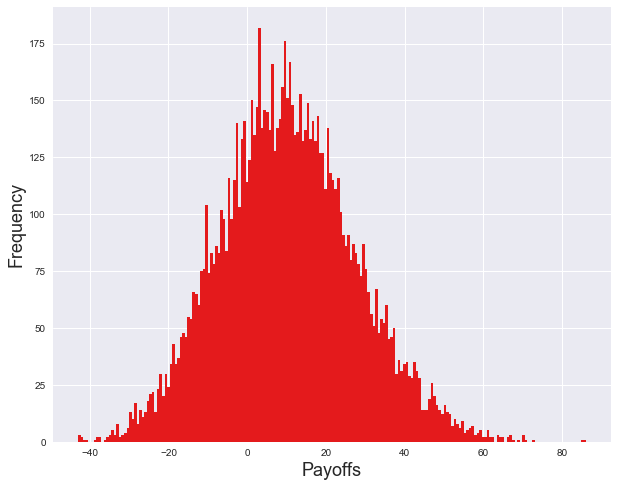

In [11]:
plt.hist(payoffs, bins=200)
plt.grid(True)
plt.xlabel('Payoffs',fontsize =18)
plt.ylabel('Frequency',fontsize =18)
plt.show()
# tag: distribution of payoffs
# title: Histogram of potential payoffs

## Price
#### Inputs

In [12]:
S = 600 # Underlying price
v = 0.2 # vol
r = 0.01 # risk free rate
T = (datetime.date(2018,8,15)-datetime.date(2018,7,16)).days/365 # time to maturity
K = 580 # strike
weight = 0.5 # weight-above strike
simulations = 1000 # no. of simulation

#### Results

In [13]:
# Two Prices
results=np.ones(2)
results[0]=BS_value(S, K, r, T, v,'C')# option price by Black
results[1]= mc(S,v,r,T,K,weight,simulations) # option price by MC
print('Black Price: %0.4f' % results[0],'MC Price: %0.4f' % results[1])

Black Price: 25.7644 MC Price: 10.6824


## PART 2: Greeks


## PART 3: Scenario 1(Changing weight)
weight = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]


In [14]:
weight = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
sc_price = np.ones(len(weight))
for i in np.arange(len(weight)):
    sc_price[i] = mc(S,v,r,T,K,weight[i],simulations)
    print('Weight %0.4f Price is : %0.4f' % (weight[i],sc_price[i]))

Weight 0.1000 Price is : -2.3571
Weight 0.2000 Price is : 0.1075
Weight 0.3000 Price is : 3.7991
Weight 0.4000 Price is : 7.7729
Weight 0.5000 Price is : 9.5757
Weight 0.6000 Price is : 13.5290
Weight 0.7000 Price is : 16.5568
Weight 0.8000 Price is : 19.7115
Weight 0.9000 Price is : 21.8852
Weight 1.0000 Price is : 25.6775
